# Stochastic HMC Example: Logistic Regression

#### Kezi Cheng, Michael Lee, Daniel Olal, Victor Sheng
#### Harvard University, 29 Oxford Street, Cambridge MA 02138

**References:**
http://christianherta.de/lehre/dataScience/machineLearning/mcmc/logisticRegressionPymc3.slides.php
https://github.com/gldmt-duke/CokerAmitaiSGHMC/blob/master/logistic_regression/logistic_regression_simulated.ipynb

In [1]:
#import numpy as np
from autograd import numpy as np
from autograd import grad
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
np.random.seed(100)

In [2]:
fontsize=16

# function for plotting decision boundaries

def plot_decision_boundaries(r0, r1, p_trace, ax):
    accuracy_list = []
    pa = p_trace
    ax.scatter(r0[...,0], r0[...,1], c='b', marker='o', label="Class 0")
    ax.scatter(r1[...,0], r1[...,1], c='r', marker='x', label="Class 1")
    ax.set_xlabel("$x_1$", size=fontsize)
    ax.set_ylabel("$x_2$", size=fontsize)

    x0 = np.array([-8.,10.])
    x1 = - (pa[:,1].mean() * x0 + pa[:,0].mean())/pa[:,2].mean() 
    ax.plot(x0, x1,'k-',lw=3, label="Mean Decision Boundary")

    x1_ = - (pa[:,1] * x0[:, None] + pa[:,0])/pa[:,2]
    x1_ = x1_[:, -1000:]
    pa = pa[-1000:]

    for i in range(x1_.shape[1]):
        ax.plot(x0, x1_[:,i], c='g', alpha=0.02)
        r0_results = pd.DataFrame(r0)
        r1_results = pd.DataFrame(r1)
        r0_results["class"]=0
        r1_results["class"]=1
        r_combined = pd.concat([r0_results, r1_results])
        x1_calc = - (pa[:,1][i] * -8 + pa[:,0][i])/pa[:,2][i]
        r_combined['predict'] = np.where(r_combined[1] > - (pa[:,1][i] * r_combined[0] + pa[:,0][i])/pa[:,2][i], 0, 1)
        cm = confusion_matrix(r_combined["class"], r_combined['predict']) 
        accuracy = accuracy_score(r_combined["class"], r_combined['predict'])
        accuracy_list.append(accuracy)
    ax.plot([], [], ' ', label="Accuracy: {}".format(np.round(np.mean(accuracy),2)))
    ax.legend()
    _ = ax.set_xlim(-6,6)
    _ = ax.set_ylim(-6,6)  

In [3]:
# function for plotting traceplots

def plot_traceplot(nsample, sample_results, nbatch, stepsize,B, C, D):
  fig, ax = plt.subplots(1,3, figsize=(14,4))
  
  ax[0].plot(np.arange(nsample), sample_results[:,0])
  ax[0].set_title('Intercept', size = fontsize)
  ax[0].set_xlabel('Iterations', size=fontsize)
  ax[0].set_ylabel('intercept coefficient value', size=fontsize)

  ax[1].plot(np.arange(nsample), sample_results[:,1])
  ax[1].set_title('$x_1$', size =fontsize)
  ax[1].set_xlabel('Iterations', size=fontsize)
  ax[1].set_ylabel('$x_1$ coefficient value', size=fontsize)

  ax[2].plot(np.arange(nsample), sample_results[:,2])
  ax[2].set_title('$x_1$', size = fontsize)
  ax[2].set_xlabel('Iterations', size=fontsize)
  ax[2].set_ylabel('$x_2$ coefficient value', size=fontsize)

  plt.suptitle('SGHMC with {} samples, Batch:{}, Stepsize: {}, B:{:.0f}, C:{}, D:{:.3f}'.format(nsample, nbatch, stepsize, B, C, D), size=20, y=1.04) 
  plt.tight_layout(pad=1.001, h_pad=None, w_pad=None, rect=None)


In [4]:
# Logistic regression function
def logistic_regression(x):
    return 1/(1+np.exp(-x))

# Define the energy function (log posterior) of the likelihood + prior
def U_logistic_regression(theta, Y, X, phi):
    '''
    The logistic posterior is given by binomial likelihood + gaussian prior
    '''
    likelihood = Y.T @ X @ theta - np.sum(np.log(1+np.exp(X @ theta))) 
    prior = - 0.5 * phi * np.sum(theta**2)
    logposterior = likelihood + prior
    return - logposterior

# use autograd to evaluate gradients
potential_grad = grad(U_logistic_regression)

# HMC Sampler
def hmc(Y, X, U, M, eps, m, theta0, phi):
    '''
    theta is the parameter we want to sample
    eps is the stepsize during the leapfrog step
    m is the number of leapfrog iterations
    phi is the standard deviation of the prior
    M is the covariance matrix of the data
    '''
    theta = theta0.copy()
    n, p = X.shape
    
    # Precompute
    
    #Calculate the precision
    Minv = np.linalg.inv(M)
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)
    r = r.reshape(-1,1)
    
    # Intial energy
    
    # The potential energy U(theta0, Y, X, phi) + kinetic energy 0.5 * np.asscalar(r.T @ Minv @ r)
    H0 = U(theta0, Y, X, phi) + 0.5 * np.asscalar(r.T @ Minv @ r)
    
    # Hamiltonian dynamics
    
    r -= (eps/2)*potential_grad(theta, Y, X, phi).reshape(-1,1) # Calculate half step momentum

    for i in range(m):
        theta += (eps*Minv@r).ravel() # calculate the full step gradient
        r -= eps*potential_grad(theta, Y, X, phi).reshape(-1,1) # calculate another 
    
    r -= (eps/2)*potential_grad(theta, Y, X, phi).reshape(-1,1) # calculate half step momentum
    
    # Final energy
    
    # calculate the new energy based on new momentum & potential energy
    H1 = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r) 
    
    # MH step
    u = np.random.uniform() # Flip a coin
    
    # compare the new energy and the old energy
    
    rho = np.exp(H0 - H1) # Acceptance probability
    
    if u < np.min((1, rho)): # accept
        accept = True
        H = H1
        
    else:
        theta = theta0 # reject
        accept = False
        H = H0

    return theta, accept, rho, H

# Stochastic HMC Sampler
def sghmc(Y, X, U, M, Minv, eps, m, theta, D, phi, nbatch):
    
    n, p = X.shape
      
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]

    # Hamiltonian dynamics
    for i in range(m):    
        batch_idx = np.random.choice(np.arange(n),nbatch,replace=False)
        theta += (eps*Minv@r).ravel()
        
        stochastic_grad=(n/nbatch * (potential_grad(theta, Y[batch_idx], X[batch_idx], phi).reshape(-1,1)))

        r -= eps * stochastic_grad - eps*C @ Minv @ r \
            + np.random.multivariate_normal(np.zeros(p),D)[:,np.newaxis]
        
    # Record the energy
    H = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    return theta, H


In [5]:
np.random.seed(60)

n_classes = 2
weights=list(np.ones(2)/n_classes)

X1, Y1 = make_classification(n_samples=2000, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, flip_y=0.05)


In [6]:
Xvals=pd.DataFrame(X1, columns=['x1', 'x2'])
yvals=pd.DataFrame(Y1, columns=['target'])
df=pd.concat([Xvals,yvals], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df.target, test_size=.4)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1200, 2) (800, 2) (1200,) (800,)


In [8]:
vals0=X_train[y_train == 0]
vals1=X_train[y_train == 1]
print(vals0.shape, vals1.shape)

(589, 2) (611, 2)


In [9]:
# add an extra column 0 with 1 
X_train = np.concatenate((np.ones((len(X_train),1)), X_train), axis=1)

In [10]:
nsample = 2000
m = 20
eps = .01

p = X_train.shape[1]

theta = np.zeros(p)
phi = 5
M = np.identity(p)

# Allocate space
hmc_samples = np.zeros((nsample, p))
accept = np.zeros(nsample)
rho = np.zeros(nsample)
H = np.zeros(nsample)

# HMC Sampler

for i in range(nsample):
    theta, accept[i], rho[i], H[i] = hmc(y_train.values.flatten(), X_train, U_logistic_regression, M, eps, m, theta, phi)
    hmc_samples[i] = theta

In [11]:
trace_logistic_hmc=pd.DataFrame(hmc_samples, columns=['Intercept','x1', 'x2'])
trace_logistic_hmc.head()

,Intercept,x1,x2
0,0.179316,-4.851626,-1.403498
1,0.179316,-4.851626,-1.403498
2,0.179316,-4.851626,-1.403498
3,0.179316,-4.851626,-1.403498
4,0.179316,-4.851626,-1.403498


In [12]:
params_trace_hmc = np.concatenate((trace_logistic_hmc['Intercept'][:, None], trace_logistic_hmc['x1'][:, None], trace_logistic_hmc['x2'][:, None]), axis=1)

In [13]:
# def plot_data(r0, r1):
#     plt.figure(figsize=(16.,9.))
#     sns.set(rc={'figure.figsize':(16,9)})
#     plt.scatter(r0[...,0], r0[...,1], c='b', marker='o', label="Class 0")
#     plt.scatter(r1[...,0], r1[...,1], c='r', marker='x', label="Clase 1")
#     plt.xlabel("$x_1$", size=20)
#     plt.ylabel("$x_2$", size=20)

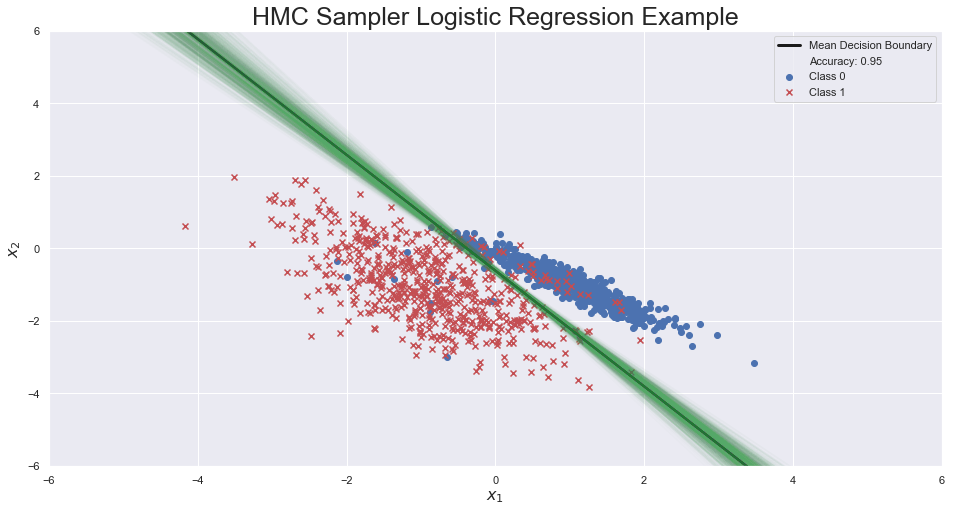

In [14]:
# Plotting the decision boundaries for different 
# parameters obtained from the trace
fig, ax = plt.subplots(1,1)
plot_decision_boundaries(vals0.values,vals1.values, params_trace_hmc, ax)
plt.title('HMC Sampler Logistic Regression Example',size=25)
plt.savefig('data/HMC.png', bbox_inches="tight")
plt.show()

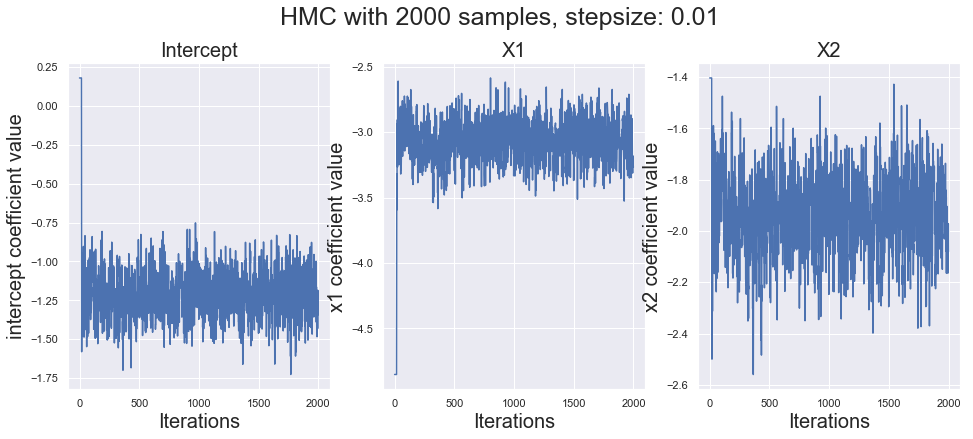

In [15]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
fig, ax = plt.subplots(1,3, figsize=(16,6))
ax[0].plot(np.arange(nsample), trace_logistic_hmc['Intercept'])
ax[0].set_title('Intercept', size = 20)
ax[0].set_xlabel('Iterations', size=20)
ax[0].set_ylabel('intercept coefficient value', size=20)

ax[1].plot(np.arange(nsample), trace_logistic_hmc['x1'])
ax[1].set_title('X1', size = 20)
ax[1].set_xlabel('Iterations', size=20)
ax[1].set_ylabel('x1 coefficient value', size=20)

ax[2].plot(np.arange(nsample), trace_logistic_hmc['x2'])
ax[2].set_title('X2', size = 20)
ax[2].set_xlabel('Iterations', size=20)
ax[2].set_ylabel('x2 coefficient value', size=20)

plt.suptitle('HMC with {} samples, stepsize: 0.01'.format(nsample), size=25, y=1.01)
plt.show()

# Stochastic Gradient HMC Implementation

## Effect of Changing the Friction Term C

In [16]:
# Varying Friction Term

nsample = 2000
m = 20
eps = 0.001

n, p = X_train.shape

theta = np.zeros(p)
M = np.identity(p) 
phi = 5
nbatch = 500

# Precompute
M = np.identity(p)
Minv = np.linalg.inv(M)
V = 0 * np.identity(p)
B = 0.5 * V * eps

# Run sghmc

# gridsearch of optimal C value
c_list = [1,10,100,500]

samples_c = []
d_list = []

for c in c_list: 
    sghmc_samples_1 = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    for i in range(nsample):
        C = c * np.identity(p)
        D = 2*(C-B)*eps
        theta, H[i] = sghmc(y_train.values, X_train, U_logistic_regression,  M, Minv, eps, m, theta, D, phi, nbatch)
        sghmc_samples_1[i] = theta
    d_list.append(D)
    samples_c.append(sghmc_samples_1)

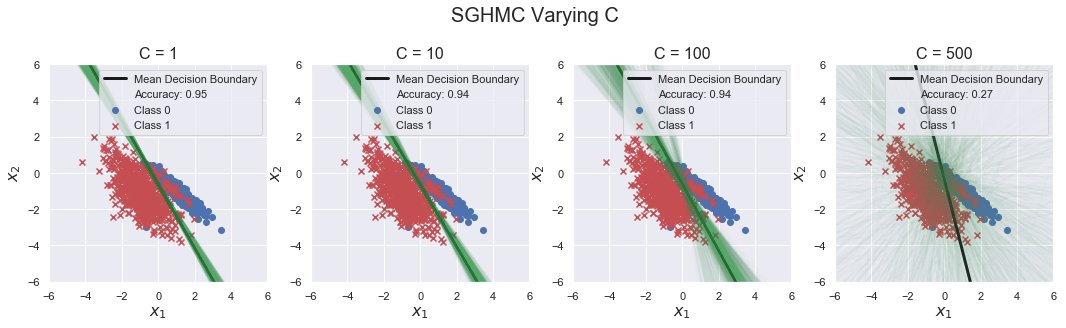

In [17]:
# Plot results of changing friction

fig, ax = plt.subplots(1,4, figsize=(18,4))

plot_decision_boundaries(vals0.values,vals1.values, samples_c[0], ax=ax[0])
ax[0].set_title('C = {}'.format(c_list[0]), size=fontsize)
ax[0].set_xlabel('$x_1$', size=fontsize)
ax[0].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_c[1], ax=ax[1])
ax[1].set_title('C = {}'.format(c_list[1]), size=fontsize)
ax[1].set_xlabel('$x_1$', size=fontsize)
ax[1].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_c[2], ax=ax[2])
ax[2].set_title('C = {}'.format(c_list[2]), size=fontsize)
ax[2].set_xlabel('$x_1$', size=fontsize)
ax[2].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_c[3], ax=ax[3])
ax[3].set_title('C = {}'.format(c_list[3]), size=fontsize)
ax[3].set_xlabel('$x_1$', size=fontsize)
ax[3].set_ylabel('$x_2$', size=fontsize)

plt.suptitle('SGHMC Varying C', size=20, y=1.08)
plt.legend
plt.savefig('data/friction_c.png', bbox_inches="tight")
plt.show()


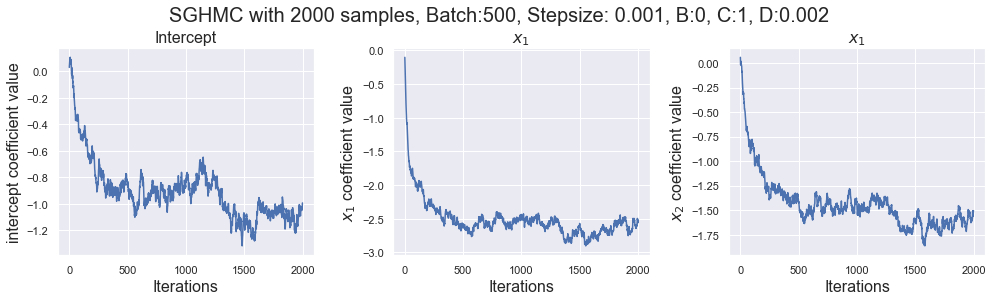

In [18]:
plot_traceplot(nsample, samples_c[0], nbatch, eps, B[0][0], c_list[0], d_list[0][0][0])

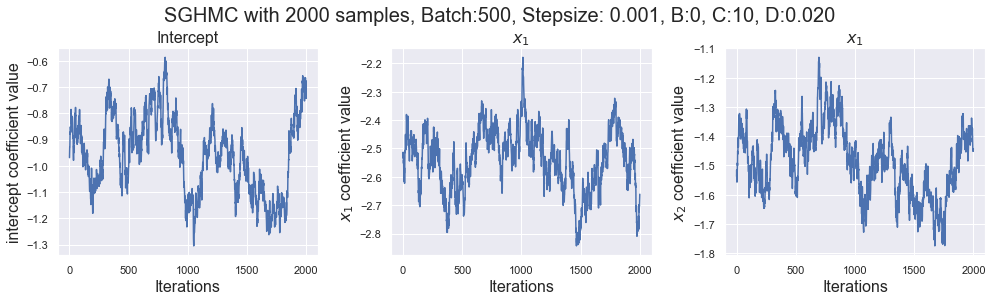

In [19]:
plot_traceplot(nsample, samples_c[1], nbatch, eps, B[0][0], c_list[1], d_list[1][0][0])

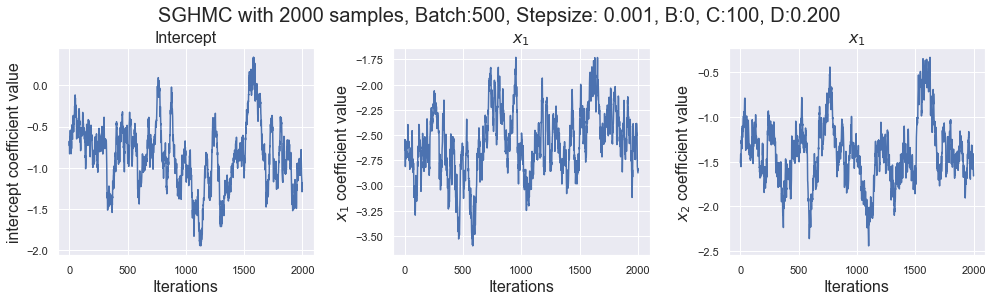

In [20]:
plot_traceplot(nsample, samples_c[2], nbatch, eps, B[0][0], c_list[2], d_list[2][0][0])

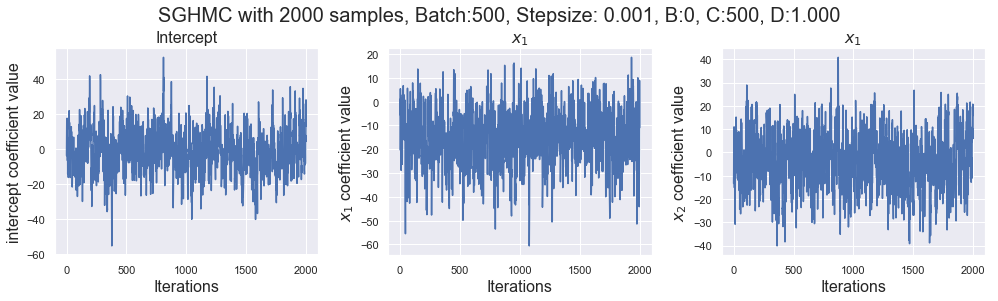

In [21]:
plot_traceplot(nsample, samples_c[3], nbatch, eps, B[0][0], c_list[3], d_list[3][0][0])

#### Based on our results, we conclude that large friction terms increase the uncertainty in our parameter estimates.  The highest accuracy of the logistic regression model occurs when the friction term is 0.5.

## Effect of Changing the Noise Term B

In [22]:
# nsample = 2000
m = 20
eps = 0.001
theta = np.zeros(p)

phi = 5
nbatch = 500
C = 1 * np.identity(p)
V = 100 * np.identity(p)
M = np.identity(p)

n, p = X_train.shape

# Precompute
Minv = np.linalg.inv(M)
B = 0.5 * V * eps
D = 2*(C-B)*eps

# Allocate space
sghmc_samples_4 = np.zeros((nsample, p))
H = np.zeros(nsample)

# Run sghmc

V_list = [0,200,2000,20000]

samples_B = []
b_list = []
d_list = []

for V_val in V_list: 
    sghmc_samples_2 = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    for i in range(nsample):
        B_val = 0.5 * V_val * eps
        D = 2*(C-B_val)*eps
        theta, H[i] = sghmc(y_train.values, X_train, U_logistic_regression,  M, Minv, eps, m, theta, D, phi, nbatch)
        sghmc_samples_2[i] = theta
    b_list.append(B_val)
    d_list.append(D)

    samples_B.append(sghmc_samples_2)


C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return f_raw(*args, **kwargs)


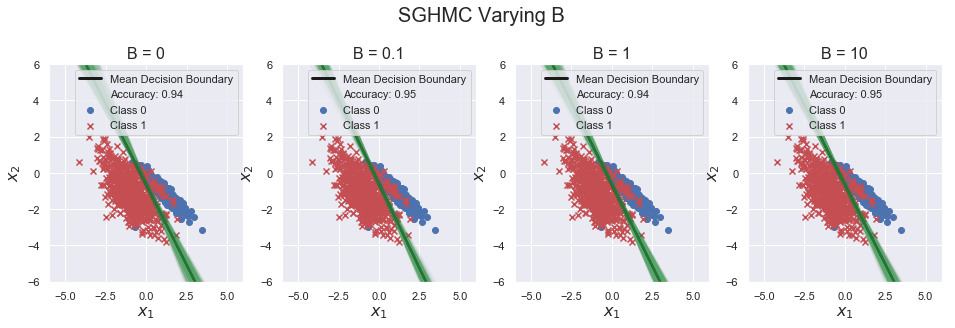

In [23]:
# Plot results of changing noise

fig, ax = plt.subplots(1,4, figsize=(16,4))

plot_decision_boundaries(vals0.values,vals1.values, samples_B[0], ax=ax[0])
ax[0].set_title('B = {:.0f}'.format(b_list[0]), size=fontsize)
ax[0].set_xlabel('$x_1$', size=fontsize)
ax[0].set_ylabel('$x_2$', size=fontsize)
# ax[0].legend()

plot_decision_boundaries(vals0.values,vals1.values, samples_B[1], ax=ax[1])
ax[1].set_title('B = {:.1f}'.format(b_list[1]), size =fontsize)
ax[1].set_xlabel('$x_1$', size=fontsize)
ax[1].set_ylabel('$x_2$', size=fontsize)


plot_decision_boundaries(vals0.values,vals1.values, samples_B[2], ax=ax[2])
ax[2].set_title('B = {:.0f}'.format(b_list[2]), size=fontsize)
ax[2].set_xlabel('$x_1$', size=fontsize)
ax[2].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_B[3], ax=ax[3])
ax[3].set_title('B = {:.0f}'.format(b_list[3]), size=fontsize)
ax[3].set_xlabel('$x_1$', size=fontsize)
ax[3].set_ylabel('$x_2$', size=fontsize)


plt.suptitle('SGHMC Varying B', size=20, y=1.08)
plt.savefig('data/noise_b.png', bbox_inches="tight")
plt.legend
plt.show()

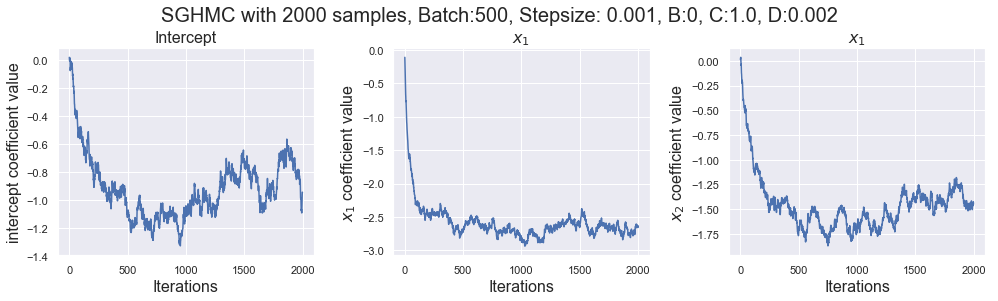

In [24]:
plot_traceplot(nsample, samples_B[0], nbatch, eps, b_list[0], C[0][0], d_list[0][0][0])

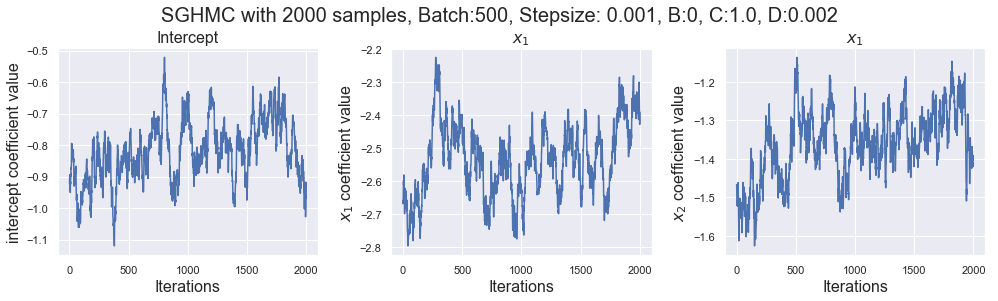

In [25]:
plot_traceplot(nsample, samples_B[1], nbatch, eps, b_list[1], C[0][0], d_list[1][0][0])

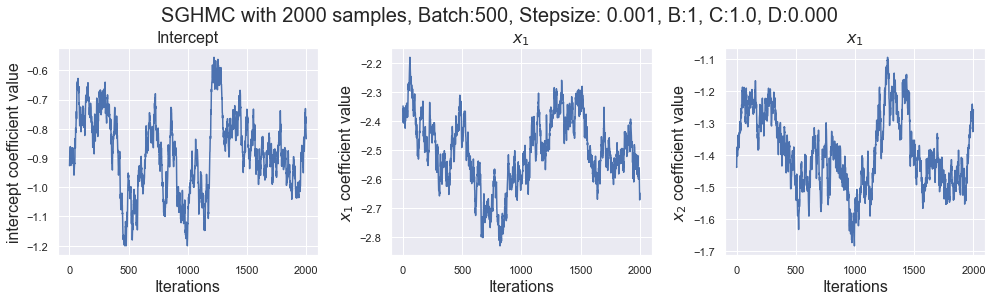

In [26]:
plot_traceplot(nsample, samples_B[2], nbatch, eps, b_list[2], C[0][0], d_list[2][0][0])

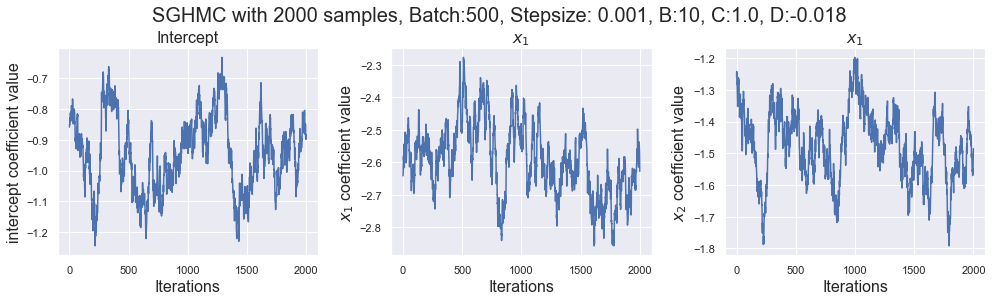

In [27]:
plot_traceplot(nsample, samples_B[3], nbatch, eps, b_list[3], C[0][0], d_list[3][0][0])

#### We do not see a large difference in logistic regression classification accuracy when we adjust the noise term B. The uncertainty in the parameter estimates is also similar for all values of B.  

## Effect of Changing the Batch Size 

In [28]:
# nsample = 2000
m = 20
eps = 0.001
phi = 5
# nbatch = 50
n, p = X_train.shape
theta = np.zeros(p)

C = 1 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)
# Precompute
Minv = np.linalg.inv(M)
B = 0.5 * V * eps
D = 2*(C-B)*eps

# Run sghmc

batch_size = [50,250,500,1000]

samples_batch = []

for batch in batch_size: 
    sghmc_samples_3 = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    for i in range(nsample):
        theta, H[i] = sghmc(y_train.values, X_train, U_logistic_regression,  M, Minv, eps, m, theta, D, phi, batch)
        sghmc_samples_3[i] = theta

    samples_batch.append(sghmc_samples_3)

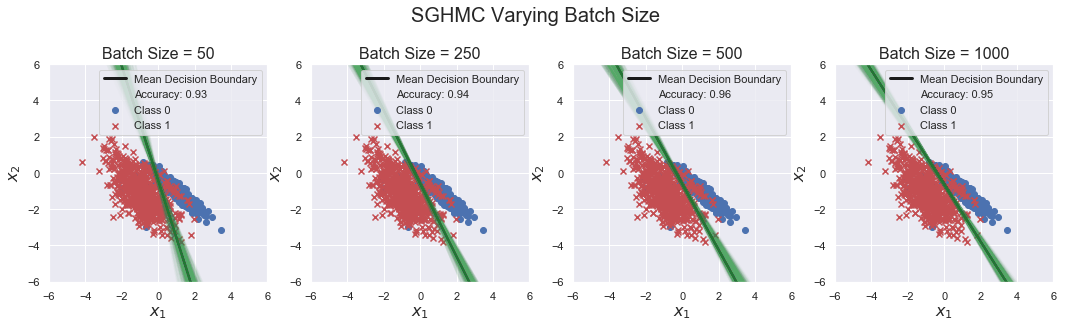

In [29]:
# Plot results of changing batch size

fig, ax = plt.subplots(1,4, figsize=(18,4))

plot_decision_boundaries(vals0.values,vals1.values, samples_batch[0], ax=ax[0])
ax[0].set_title('Batch Size = {:.0f}'.format(batch_size[0]), size=fontsize)
ax[0].set_xlabel('$x_1$', size=fontsize)
ax[0].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_batch[1], ax=ax[1])
ax[1].set_title('Batch Size = {:.0f}'.format(batch_size[1]), size =fontsize)
ax[1].set_xlabel('$x_1$', size=fontsize)
ax[1].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_batch[2], ax=ax[2])
ax[2].set_title('Batch Size = {:.0f}'.format(batch_size[2]), size=fontsize)
ax[2].set_xlabel('$x_1$', size=fontsize)
ax[2].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_batch[3], ax=ax[3])
ax[3].set_title('Batch Size = {:.0f}'.format(batch_size[3]), size=fontsize)
ax[3].set_xlabel('$x_1$', size=fontsize)
ax[3].set_ylabel('$x_2$', size=fontsize)

plt.suptitle('SGHMC Varying Batch Size', size=20, y=1.08)
plt.legend
plt.savefig('data/batchsize.png', bbox_inches="tight")
plt.show()

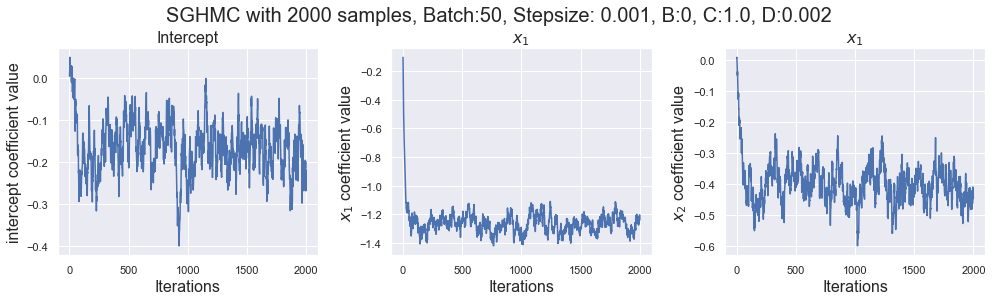

In [30]:
plot_traceplot(nsample, samples_batch[0], batch_size[0], eps, B[0][0], C[0][0], D[0][0])

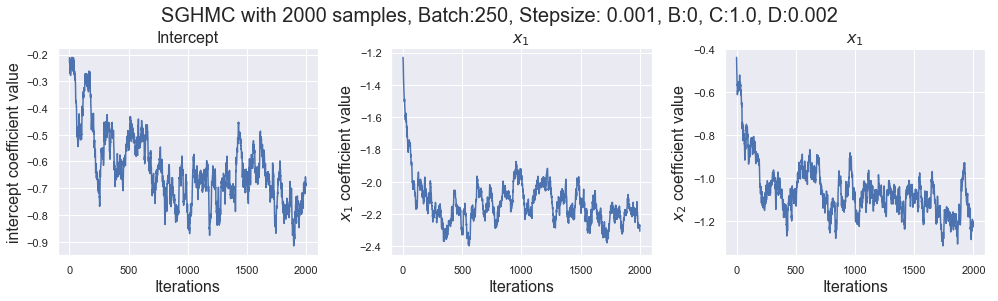

In [31]:
plot_traceplot(nsample, samples_batch[1], batch_size[1], eps, B[0][0], C[0][0], D[0][0])

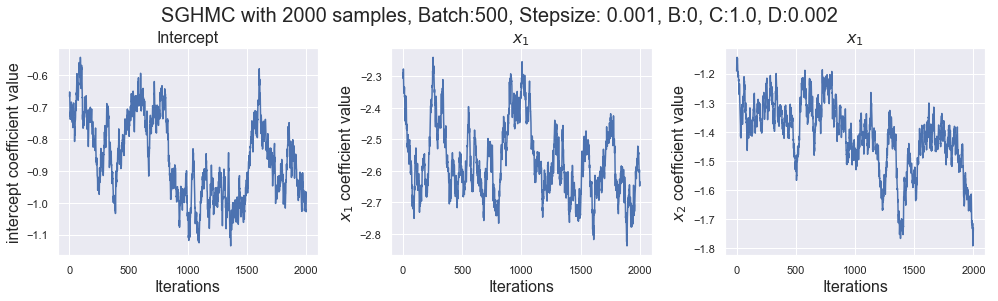

In [32]:
plot_traceplot(nsample, samples_batch[2], batch_size[2], eps, B[0][0], C[0][0], D[0][0])

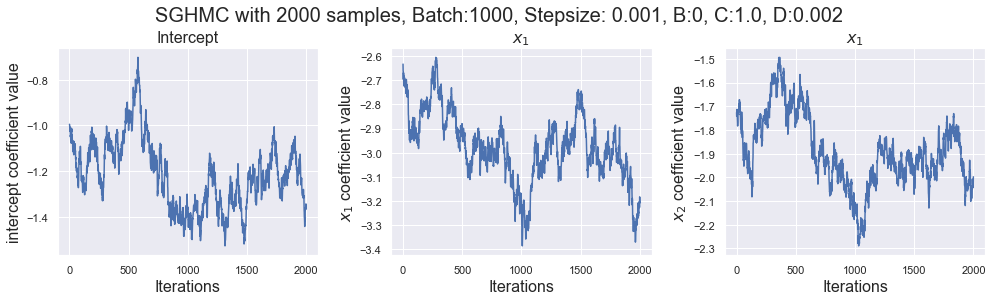

In [33]:
plot_traceplot(nsample, samples_batch[3], batch_size[3], eps, B[0][0], C[0][0], D[0][0])

#### The logistic regression model accuracy appears to be the highest with a batch size of 500.  The uncertainty in our parameter estimates increases when we decrease the batch size.  

## Effect of Changing the Step Size

In [34]:
# nsample = 2000
m = 20
phi = 5
nbatch = 500
n, p = X_train.shape
theta = np.zeros(p)


C = 1 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)
# Precompute
Minv = np.linalg.inv(M)
B = 0 * V * eps
D = 2*(C-B)*eps

# Run sghmc

step_size = [0.001,0.005, 0.01, 0.025]

samples_step = []

for step in step_size: 
    sghmc_samples_4 = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    for i in range(nsample):
        theta, H[i] = sghmc(y_train.values, X_train, U_logistic_regression,  M, Minv, step, m, theta, D, phi, batch)
        sghmc_samples_4[i] = theta

    samples_step.append(sghmc_samples_4)

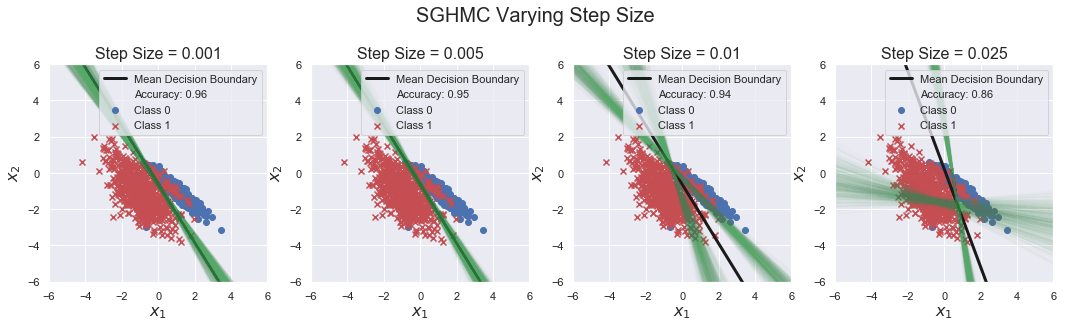

In [35]:
# Plot results of changing step size

fig, ax = plt.subplots(1,4, figsize=(18,4))

plot_decision_boundaries(vals0.values,vals1.values, samples_step[0], ax=ax[0])
ax[0].set_title('Step Size = {}'.format(step_size[0]), size=fontsize)
ax[0].set_xlabel('$x_1$', size=fontsize)
ax[0].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_step[1], ax=ax[1])
ax[1].set_title('Step Size = {}'.format(step_size[1]), size =fontsize)
ax[1].set_xlabel('$x_1$', size=fontsize)
ax[1].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_step[2], ax=ax[2])
ax[2].set_title('Step Size = {}'.format(step_size[2]), size=fontsize)
ax[2].set_xlabel('$x_1$', size=fontsize)
ax[2].set_ylabel('$x_2$', size=fontsize)

plot_decision_boundaries(vals0.values,vals1.values, samples_step[3], ax=ax[3])
ax[3].set_title('Step Size = {}'.format(step_size[3]), size=fontsize)
ax[3].set_xlabel('$x_1$', size=fontsize)
ax[3].set_ylabel('$x_2$', size=fontsize)

plt.suptitle('SGHMC Varying Step Size', size=20, y=1.08)
plt.legend
plt.savefig('data/stepsize.png', bbox_inches="tight")
plt.show()

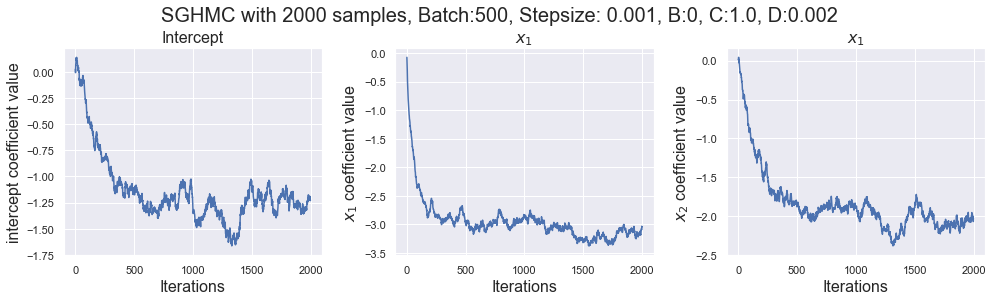

In [36]:
plot_traceplot(nsample, samples_step[0], nbatch, step_size[0], B[0][0], C[0][0], D[0][0])

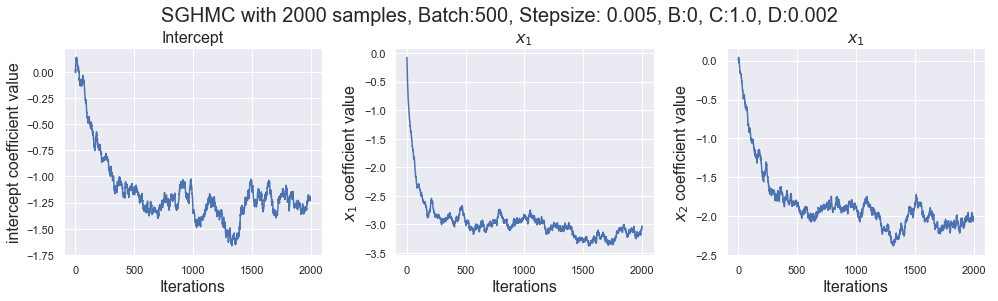

In [37]:
plot_traceplot(nsample, samples_step[0], nbatch, step_size[1], B[0][0], C[0][0], D[0][0])

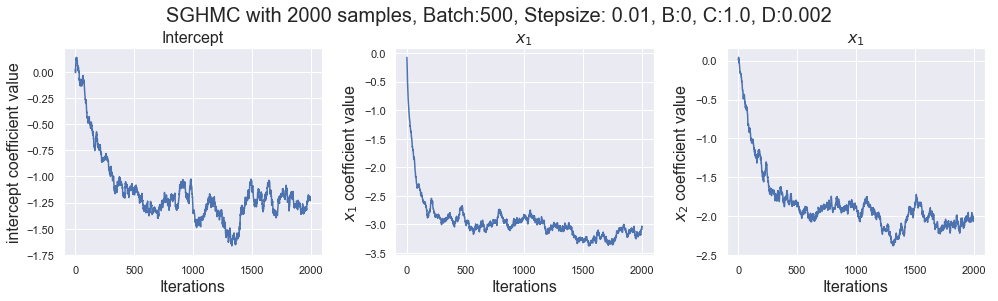

In [38]:
plot_traceplot(nsample, samples_step[0], nbatch, step_size[2], B[0][0], C[0][0], D[0][0])

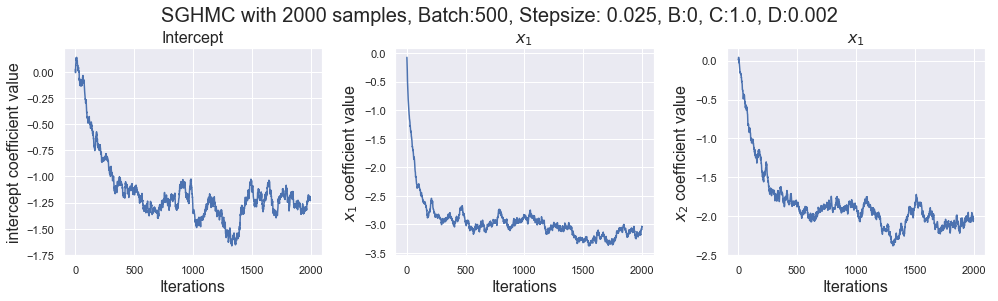

In [39]:
plot_traceplot(nsample, samples_step[0], nbatch, step_size[3], B[0][0], C[0][0], D[0][0])

#### As expected, the step size has a significant effect on the accuracy of SGHMC sampler. As we increase the stepsize greater than 0.005, the classification accuracy decreases and the level of uncertainty in the parameter estimates increases significantly.  